# Imports

In [2]:
# Notebook extensions
%load_ext autoreload

# Std Python Lib
import itertools
from collections import defaultdict
from collections import Counter
import time
from pprint import pprint

# Requirements
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from scipy.stats import linregress
from adjustText import adjust_text
from tqdm.notebook import tqdm

# Project
import distances
import compressions
import s_curves

from corpus import brunet
from corpus import oxquarry
from corpus import st_jean
from corpus import pan16


from rank_list_fusion import fusion_z_score
from rank_list_fusion import fusion_regression_training
from rank_list_fusion import fusion_regression

from evaluate import evaluate_linking
from evaluate import evaluate_clustering

from linking import compute_links
from linking import most_frequent_word

from clustering import supervised_clustering_training
from clustering import supervised_clustering_predict
from clustering import unsupervised_clustering
from clustering import clustering_at_every_n_clusters

from misc import sign_test
from misc import first_letters_cut
from misc import word_n_grams
from misc import last_letters_cut
from misc import sigmoid
from misc import sigmoid_r
from misc import compute_r
from misc import normalize
from misc import rank_list_distance
from misc import dataset_infos

%autoreload 2

## Settings

In [3]:
np.set_printoptions(precision=2, floatmode="fixed", suppress=True)
mpl.rcParams["figure.facecolor"] = "w"

# Corpus

## Load

In [4]:
print("Loading Oxquarry")
info_oxquarry, X_token_oxquarry, Y_oxquarry = oxquarry.parse()
print("Loading Brunet")
info_brunet, X_lemma_brunet, X_token_brunet, Y_brunet = brunet.parse()
print("Loading St-Jean A")
info_st_jean_A, X_pos_st_jean_A, X_lemma_st_jean_A, X_token_st_jean_A, Y_st_jean_A = st_jean.parse_A()
print("Loading St-Jean B")
info_st_jean_B, X_pos_st_jean_B, X_lemma_st_jean_B, X_token_st_jean_B, Y_st_jean_B = st_jean.parse_B()
print("Loading St-Jean")
info_st_jean, X_pos_st_jean, X_lemma_st_jean, X_token_st_jean, Y_st_jean = st_jean.parse()

Loading Oxquarry
Loading Brunet
Loading St-Jean A
Loading St-Jean B
Loading St-Jean


## Informations

In [5]:
print("Name, Language, authors, texts, r, true_links, links, true_links_ratio, mean_length")
id, x, y = oxquarry.parse()
print("Oxquarry EN", *dataset_infos(x, y))
id, x_lemma, x, y = brunet.parse()
print("Brunet FR", *dataset_infos(x, y))
id, x_pos, x_lemma, x, y = st_jean.parse()
print("St-Jean FR", *dataset_infos(x, y))
print("St-Jean A 001-100 FR", *dataset_infos(x[:100], y[:100]))
print("St-Jean B 101-200 FR", *dataset_infos(x[100:], y[100:]))

problems = pan16.parse_train()
for (info, _, x, y) in problems:
    print(f"PAN16 {info['language']} {info['folder']}", *dataset_infos(x, y))
problems = pan16.parse_test()
for (info, _, x, y) in problems:
    print(f"PAN16 {info['language']} {info['folder']}", *dataset_infos(x, y))

Name, Language, authors, texts, r, true_links, links, true_links_ratio, mean_length
Oxquarry EN 9 52 0.173 160 1326 0.121 11650 3.819
Brunet FR 11 44 0.25 66 946 0.07 9778 4.013
St-Jean FR 30 200 0.15 670 19900 0.034 11533 3.928
St-Jean A 001-100 FR 17 100 0.17 330 4950 0.067 11552 3.949
St-Jean B 101-200 FR 19 100 0.19 258 4950 0.052 11513 3.907
PAN16 en problem001 35 50 0.7 26 1225 0.021 872 4.161
PAN16 en problem002 25 50 0.5 75 1225 0.061 881 4.118
PAN16 en problem003 43 50 0.86 8 1225 0.007 867 4.113
PAN16 en problem004 55 80 0.688 36 3160 0.011 1125 4.283
PAN16 en problem005 70 80 0.875 12 3160 0.004 1252 4.318
PAN16 en problem006 40 80 0.5 65 3160 0.021 1180 4.305
PAN16 nl problem007 51 57 0.895 7 1596 0.004 1261 4.582
PAN16 nl problem008 28 57 0.491 76 1596 0.048 1533 4.648
PAN16 nl problem009 40 57 0.702 30 1596 0.019 1184 4.613
PAN16 nl problem010 54 100 0.54 77 4950 0.016 145 4.41
PAN16 nl problem011 67 100 0.67 46 4950 0.009 152 4.393
PAN16 nl problem012 91 100 0.91 10 4950

## Retained text representations
See section Evaluation.Rank_Lists

In [6]:
def tr9(X_token, X_pos):
    return [
        [X_token, 0, 750, True, 1e-1, distances.cosine_distance],
        [X_token, 0, 750, False, 1e-1, distances.clark],
        [X_token, 0, 750, True, 1e-1, distances.manhattan],
        [X_token, 0, 750, False, 1e-1, distances.tanimoto],
        [X_token, 3, 3000, True, 1e-1, distances.cosine_distance],
        [X_token, 4, 8000, True, 1e-1, distances.cosine_distance],
        (X_token, compressions.bz2, distances.cbc),
        [X_pos, 2, 250, True, 1e-1, distances.cosine_distance],
        [X_pos, 3, 1000, True, 1e-1, distances.manhattan],
    ]


def tr7(X_token):
    return [
        [X_token, 0, 750, True, 1e-1, distances.cosine_distance],
        [X_token, 0, 750, False, 1e-1, distances.clark],
        [X_token, 0, 750, True, 1e-1, distances.manhattan],
        [X_token, 0, 750, False, 1e-1, distances.tanimoto],
        [X_token, 3, 3000, True, 1e-1, distances.cosine_distance],
        [X_token, 4, 8000, True, 1e-1, distances.cosine_distance],
        (X_token, compressions.bz2, distances.cbc),
    ]


def tr(*X):
    if len(X) == 2:
        return tr9(X[0], X[1])
    else:
        return tr7(X[0])

In [7]:
rls_oxquarry = [compute_links(t) for t in tr(X_token_oxquarry)]
print(np.array([evaluate_linking(rl, Y_oxquarry) for rl in rls_oxquarry]))

[[ 0.89  0.79 92.00]
 [ 0.89  0.80 88.00]
 [ 0.67  0.56 39.00]
 [ 0.63  0.57 54.00]
 [ 0.77  0.68 61.00]
 [ 0.78  0.68 84.00]
 [ 0.79  0.69 74.00]]


In [8]:
rls_brunet = [compute_links(t) for t in tr(X_token_brunet)]
print(np.array([evaluate_linking(rl, Y_brunet) for rl in rls_brunet]))

[[ 0.72  0.64 19.00]
 [ 0.71  0.67  8.00]
 [ 0.68  0.62 19.00]
 [ 0.67  0.64 22.00]
 [ 0.73  0.67 24.00]
 [ 0.74  0.67 20.00]
 [ 0.76  0.70 25.00]]


In [9]:
rls_st_jean_A = [compute_links(t) for t in tr(X_token_st_jean_A, X_pos_st_jean_A)]
print(np.array([evaluate_linking(rl, Y_st_jean_A) for rl in rls_st_jean_A]))

[[ 0.78  0.69 65.00]
 [ 0.75  0.66 68.00]
 [ 0.77  0.70 99.00]
 [ 0.76  0.69 80.00]
 [ 0.71  0.61 75.00]
 [ 0.76  0.65 72.00]
 [ 0.73  0.63 83.00]
 [ 0.68  0.63 20.00]
 [ 0.77  0.69 75.00]]


In [10]:
rls_st_jean_B = [compute_links(t) for t in tr(X_token_st_jean_B, X_pos_st_jean_B)]

In [11]:
rls_st_jean = [compute_links(t) for t in tr(X_token_st_jean, X_pos_st_jean)]
print(np.array([evaluate_linking(rl, Y_st_jean) for rl in rls_st_jean]))

[[  0.78   0.70 253.00]
 [  0.74   0.66 175.00]
 [  0.76   0.70 203.00]
 [  0.75   0.69 204.00]
 [  0.74   0.64 231.00]
 [  0.78   0.68 251.00]
 [  0.70   0.62 219.00]
 [  0.73   0.65  60.00]
 [  0.75   0.69 185.00]]


In [12]:
rl_z_score_oxquarry = fusion_z_score(rls_oxquarry)
print(evaluate_linking(rl_z_score_oxquarry, Y_oxquarry))

[ 0.84  0.74 90.00]


In [13]:
rl_z_score_brunet = fusion_z_score(rls_brunet)
print(evaluate_linking(rl_z_score_brunet, Y_brunet))

[ 0.76  0.70 21.00]


In [14]:
rl_z_score_st_jean_A = fusion_z_score(rls_st_jean_A)
print(evaluate_linking(rl_z_score_st_jean_A, Y_st_jean_A))

[ 0.85  0.77 95.00]


In [15]:
rl_z_score_st_jean_B = fusion_z_score(rls_st_jean_B)
print(evaluate_linking(rl_z_score_st_jean_B, Y_st_jean_B))

[  0.96   0.90 200.00]


In [16]:
rl_z_score_st_jean = fusion_z_score(rls_st_jean)
print(evaluate_linking(rl_z_score_st_jean, Y_st_jean))

[  0.85   0.78 311.00]


# Methods

## Distance over rank

In [ ]:
rank_list = compute_links([X_token_brunet, 0, 500, False, 0.1, distances.manhattan])
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(range(len(rank_list)), [r[-1] for r in rank_list])
plt.xlabel("Rank")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("img/distance_over_rank.png")

## S-Curve

In [ ]:
scale = 500
plt.figure(figsize=(4, 3), dpi=200)

min_ = 1e-10
max_ = 20
zoom_factors = np.arange(min_, max_, 0.06)

plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", plt.cm.hsv(np.linspace(0, 1, len(zoom_factors))))

for i in zoom_factors:
    x, y = s_curves.sigmoid_reciprocal(c=i, r=0.5)(scale)
    plt.plot(x, y, linewidth=0.2)

cbar = plt.colorbar(plt.cm.ScalarMappable(
    norm=colors.Normalize(min_, max_), cmap="hsv"))
cbar.set_label("c")
plt.tight_layout()
plt.savefig("img/s_curve_c.png")

plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

---

In [ ]:
scale = 500
plt.figure(figsize=(4, 3), dpi=200)

min_ = 0.1
max_ = 0.9
rs = np.arange(min_, max_, 0.001)

plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", plt.cm.hsv(np.linspace(0, 1, len(rs))))

for ri in rs:
    x, y = s_curves.sigmoid_reciprocal(r=ri)(scale)
    plt.plot(x, y, linewidth=0.2)

cbar = plt.colorbar(plt.cm.ScalarMappable(
    norm=colors.Normalize(min_, max_), cmap="hsv"))
cbar.set_label("r")
plt.tight_layout()
plt.savefig("img/s_curve_r.png")

plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# Evaluation

## Rank lists

### Importance of the text size in stylometry

In [ ]:
M = []

sizes = np.arange(9000, 0, -250, dtype=int)

for i in sizes:
    # limitate the data size
    Xi = [x[:i] for x in X_token_st_jean]
    rl = compute_links([Xi, 0, 500, True, 0.1, distances.cosine_distance])
    m = evaluate_linking(rl, Y_st_jean)
    print(i, m)
    M.append(m)

M = np.array(M)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=200)
ax2 = ax1.twinx()
ax1.plot(sizes, M[:, 0], c="C0", ls="solid",
         label="Average Precision (AP)")
ax1.plot(sizes, M[:, 1], c="C0", ls="dashed", label="RPrec")
ax2.plot(sizes, M[:, 2], c="C0", ls="dotted", label="HPRec")
ax1.set_xlabel("#Tokens per texts")
plt.gca().invert_xaxis()
ax1.set_ylabel("AP/RPrec")
ax2.set_ylabel("HPrec")
plt.xticks(np.arange(9000, -1, -1000, dtype=int))
fig.legend()
plt.tight_layout()
plt.savefig("img/degradation.png")

### MFW Token and Lemma

In [ ]:
X_lemma, X_token, Y = X_lemma_st_jean, X_token_st_jean, Y_st_jean
# X_lemma, X_token, Y = X_lemma_brunet, X_token_brunet, Y_brunet

M_token = []
M_lemma = []

mfws = np.arange(100, 2000 + 1, 100)
distances_ = distances.vector_distances

for mfw in mfws:
    print(mfw)
    for zscore, distance in distances_:
        rl_token = compute_links([X_token, 0, mfw, zscore, 1e-1, distance])
        Mi = evaluate_linking(rl_token, Y)
        M_token.append(Mi)

        rl_lemma = compute_links([X_lemma, 0, mfw, zscore, 1e-1, distance])
        Mi = evaluate_linking(rl_lemma, Y)
        M_lemma.append(Mi)

M_token = np.array(M_token).reshape(-1, len(distances_), 3)
M_lemma = np.array(M_lemma).reshape(-1, len(distances_), 3)

In [ ]:
custom_lines = [
    Line2D([0], [0], color="k", lw=2, ls="dotted"),
    Line2D([0], [0], color="k", lw=2, ls="dashed"),
] + [Line2D([0], [0], color=f"C{i}", lw=2) for i in range(len(distances_))]
labels = ["Token", "Lemma"] + [d.__name__ for z, d in distances_]

plt.figure(figsize=(6, 8), dpi=200)
for i in range(len(distances_)):
    plt.plot(mfws, M_token[:, i, 0], ls="dashed", c=f"C{i}")
    plt.plot(mfws, M_lemma[:, i, 0], ls="dotted", c=f"C{i}")
plt.xlabel("#MFW")
plt.ylabel("Average Precision (AP)")
plt.legend(custom_lines, labels, loc="lower center", ncol=2)
plt.tight_layout()
plt.grid()
plt.savefig("img/token_vs_lemma.png")

### MFW Letters $n$-grams

In [ ]:
# X, Y = X_token_oxquarry, Y_oxquarry
# X, Y = X_token_brunet, Y_brunet
X, Y = X_token_st_jean, Y_st_jean

M = defaultdict(list)

mfws = np.arange(500, 15000 + 1, 500)

ngrams_types = [3, 4, 5, (2, 3), (3, 4), (4, 5)]
for ngrams_type in ngrams_types:
    print(ngrams_type)
    for mfw in mfws:
        rep = [X, ngrams_type, mfw, True, 1e-1, distances.cosine_distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        M[ngrams_type].append(m)
        print(mfw, m)

M = dict(M)

In [ ]:
plt.figure(figsize=(6, 4), dpi=200)
for ngrams_type in ngrams_types:
    X = mfws
    Y = [i[0] for i in M[ngrams_type]]
    plt.plot(X, Y, label=f"Letters {str(ngrams_type)}-grams")
plt.legend()
plt.xlabel("MFW")
plt.ylabel("Average Precision (AP)")
plt.tight_layout()
plt.savefig("img/letter_ngrams.png")

---

In [ ]:
# X, Y = X_token_oxquarry, Y_oxquarry
# X, Y = X_token_brunet, Y_brunet
X, Y = X_token_st_jean, Y_st_jean

configurations = [
    (3, 3000),
    (4, 8000),
]

for n_grams_type, mfw in configurations:
    for zscore, distance in distances.vector_distances:
        rep = [X, n_grams_type, mfw, zscore, 1e-1, distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        print(n_grams_type, mfw, distance.__name__, m)

### MFW First letters, last letters, word $n$-grams of tokens

In [ ]:
# X, Y = X_token_oxquarry, Y_oxquarry
# X, Y = X_token_brunet, Y_brunet
X, Y = X_token_st_jean, Y_st_jean

plt.figure(figsize=(6, 4), dpi=200)

for n, c in zip([3, 4, 5], ["C0", "C1", "C2"]):
    print(n)
    word_begin_X = first_letters_cut(X, n)
    word_ngrams_X = word_n_grams(X, n)
    word_end_X = last_letters_cut(X, n)

    M_ngrams = []
    M_first = []
    M_last = []

    mfws = np.arange(200, 4000 + 1, 100)

    for mfw in mfws:
        print(mfw)
        rep = [word_ngrams_X, 0, mfw, True,
               1e-1, distances.cosine_distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        M_ngrams.append(m[0])
        rep = [word_begin_X, 0, mfw, True, 1e-1, distances.cosine_distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        M_first.append(m[0])
        rep = [word_end_X, 0, mfw, True, 1e-1, distances.cosine_distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        M_last.append(m[0])

    plt.plot(mfws, M_ngrams, c=c, ls="solid")
    plt.plot(mfws, M_first, c=c, ls="dotted")
    plt.plot(mfws, M_last, c=c, ls="dashed")

custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
    Line2D([0], [0], color="C2", lw=2),
    Line2D([0], [0], color="k", lw=2, ls="solid"),
    Line2D([0], [0], color="k", lw=2, ls="dotted"),
    Line2D([0], [0], color="k", lw=2, ls="dashed"),
]

plt.legend(custom_lines, ["n = 3", "n = 4", "n = 5", "word n-grams",
                          "n first letters", "n last letters"], loc="lower right")
plt.xlabel("MFW")
plt.ylabel("Average Precision (AP)")
plt.tight_layout()
plt.savefig("img/first_last_letters_ngrams.png")

### MFW POS $n$-grams

In [ ]:
X, Y = X_pos_st_jean, Y_st_jean

M = defaultdict(list)

mfws = np.arange(100, 2000 + 1, 100)

ngrams_types = [2, 3, 4, (2, 3)]
for ngrams_type in ngrams_types:
    for mfw in mfws:
        rep = [X, ngrams_type, mfw, True, 1e-1, distances.cosine_distance]
        rl = compute_links(rep)
        m = evaluate_linking(rl, Y)
        M[ngrams_type].append(m)
        print(mfw, m)

M = dict(M)

In [ ]:
plt.figure(figsize=(6, 4), dpi=200)
for ngrams_type in ngrams_types:
    X = mfws
    Y = [i[0] for i in M[ngrams_type]]
    plt.plot(X, Y, label=f"POS {str(ngrams_type)}-grams")
plt.legend()
plt.xlabel("MFW")
plt.ylabel("Average Precision (AP)")
plt.tight_layout()
plt.savefig("img/pos_ngrams.png")

---

In [ ]:
X, Y = X_pos_st_jean, Y_st_jean

M = defaultdict(list)

configurations = [
    (2, 250),
    (3, 1000),
]

for ngrams_type, mfw in configurations:
    for zscore, distance in distances.vector_distances:
        rep = [X, ngrams_type, mfw, zscore, 1e-1, distance]
        rl = compute_links(rep)
        print(ngrams_type, mfw, distance.__name__, evaluate_linking(rl, Y))

### Compression based distances

In [ ]:
# X, Y = X_token_oxquarry, Y_oxquarry
X, Y = X_token_brunet, Y_brunet
# X, Y = X_token_st_jean, Y_st_jean

compression_methods = [
    compressions.lzma,
    compressions.bz2,
    compressions.gzip,
]
distance_funcs = [
    distances.ncd,
    distances.cbc,
]
distances_compressions = list(itertools.product(
    compression_methods, distance_funcs))

M = []
T = []

for i in range(3):
    for compression_method, distance_func in distances_compressions:
        print(compression_method.__name__, distance_func.__name__)
        t0 = time.time()
        rep = (X, compression_method, distance_func)
        rl = compute_links(rep)
        t = time.time() - t0
        m = evaluate_linking(rl, Y)
        M.append(m)
        T.append(t)
        print(m, t)

M = np.array(M).reshape(-1, len(distances_compressions), 3)
T = np.array(T).reshape(-1, len(distances_compressions))
M = M.mean(axis=0)
T = T.mean(axis=0)

In [ ]:
print(M)
print(T)

plt.figure(figsize=(6, 4), dpi=200)
x, y, c = M[:, 1], M[:, 0], M[:, 2]
plt.scatter(x, y, c=c, marker=".")
texts = []
for i, (compression_method, distance_func) in enumerate(distances_compressions):
    text = f"({compression_method.__name__}, {distance_func.__name__})"
    xy = (x[i], y[i])
    texts.append(plt.annotate(text, xy))
adjust_text(texts)
cbar = plt.colorbar()
plt.xlabel("RPrec")
plt.ylabel("Average precision (AP)")
cbar.set_label("HPrec")
plt.tight_layout()
plt.savefig("img/compression_evaluation.png")

## Error analysis

### Frequent errors

In [ ]:
rls = rls_st_jean
Y = Y_st_jean

top_n = 30
keep = 2

incorrectly_ranked = defaultdict(lambda: 0)

for rl in rls:
    m = evaluate_linking(rl, Y)
    print(m)
    i = 0
    for (a, b), s in rl:
        if Y[a] != Y[b]:
            i += 1
            incorrectly_ranked[(a, b)] += 1
            if i > top_n:
                break

rl = fusion_z_score(rls)
m = evaluate_linking(rl, Y)
print(m, "(overall)")
top_errors = Counter(dict(incorrectly_ranked)).most_common(keep)
print(top_errors)

features, mfw = most_frequent_word(X_token, 750, lidstone_lambda=1e-1)

def plot(a, b, filename):
    A, B = features[a, :], features[b, :]
    mean = np.mean(np.array([A, B]), axis=0)
    order_indices = np.argsort(mean)[::-1]
    A = A[order_indices]
    B = B[order_indices]
    plt.figure(figsize=(4, 3), dpi=200)
    plt.yscale("log")
    plt.bar(range(len(A)), A, width=1, label=f"{Y[a]} ({a+1})", alpha=0.5)
    plt.bar(range(len(A)), B, width=1, label=f"{Y[b]} ({b+1})", alpha=0.5)
    plt.legend()
    plt.xticks([], [])
    plt.xlabel("MFW Vector")
    plt.ylabel("Relative word frequency")
    plt.tight_layout()
    plt.savefig(filename)

for i, ((a, b), errors) in enumerate(top_errors):
    plot(a, b, f"img/mfw_vector_error_{i}.png")
    
(a, b), score = rl[0]
plot(a, b, f"img/mfw_vector_first_rl.png")

(a, b), score = rl[int(m[-1] - 1)]
plot(a, b, f"img/mfw_vector_first_last_rl.png")

(a, b), score = rl[-1]
plot(a, b, f"img/mfw_vector_last_rl.png")

### Publication date differences analysis

In [ ]:
rls = rls_st_jean
Y = Y_st_jean

s = 5

dates = [int(i[-1]) for i in info]
plt.figure(figsize=(4, 3), dpi=200)
plt.hist(dates, bins=np.arange(
    np.min(dates), np.max(dates), s), density=True, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("img/dates_distribution.png")

rl = fusion_z_score(rls)
print(evaluate_linking(rl, Y))

date_diffs = np.array([np.abs(dates[a] - dates[b]) for (a, b), s in rl])

correct = np.array([Y[a] == Y[b] for (a, b), s in rl])

r = compute_r(Y)
all_links = date_diffs
true_links = date_diffs[correct]
top_r_true_links = true_links[0:r]
false_links = date_diffs[~correct]
top_r_false_links = false_links[0:r]

def plot(data, title, color, filename):
    plt.figure(figsize=(4, 3), dpi=200)
    n, bins, patches = plt.hist(data, bins=np.arange(
        0, np.max(data), s), color=color, alpha=0.7, density=True, label="Distibution")
    mean = data.mean()
    std = data.std()
    plt.axvline(mean, c=color, linestyle="dashed",
                label=f"Mean = {mean:.2f}")
    plt.hlines(y=n.max() / 2 - n.min() / 2, xmin=mean - std // 2, xmax=mean +
               std // 2, color=color, linestyle="solid", label=f"Std = {std:.2f}")
    h, l = plt.gca().get_legend_handles_labels()
    order = [1, 0, 2]
    plt.legend([h[i] for i in order], [l[i] for i in order])
    plt.xlabel("Date difference")
    plt.ylabel("Density")
    plt.tight_layout()
    xticks = np.arange(date_diffs.min(), date_diffs.max(), 10)
    plt.xticks(xticks)
    plt.savefig(filename)

plot(all_links, "All links", "C0", "img/dates_differences_all.png")
plot(false_links, "false links", "C1", "img/dates_differences_false.png")
plot(top_r_true_links, "top-r true links, true links", "C2", "img/dates_differences_r_true.png")
plot(top_r_false_links, "top-r false links", "C3", "img/dates_differences_r_false.png")

## Rank lists fusion

### Rank list fusion evaluation

In [ ]:
rls_training, Y_training = rls_st_jean_B, Y_st_jean_B
rls_testing, Y_testing = rls_st_jean_A, Y_st_jean_A

# rls_training, Y_training = rls_st_jean_A, Y_st_jean_A
# rls_testing, Y_testing = rls_st_jean_B, Y_st_jean_B

fusion_size = 4

models = []
print("Training rank lists")
for i, rl in enumerate(rls_training):
    model, rmse = fusion_regression_training(rl, Y_training)
    models.append(model)
    mesures = evaluate_linking(rl, Y_training)
    print(i, mesures, np.array([rmse]))

M_single = []
rank_lists = []
print("Testing rank lists")
for i, rl in enumerate(rls_testing):
    rank_lists.append(rl)
    mesures = evaluate_linking(rl, Y_testing)
    M_single.append(mesures)
    print(i, mesures)

M_single = np.array(M_single)

M_single_max = []
M_single_mean = []
M_fusion_z_score = []
M_fusion_regression = []

tr_ids = np.array(
    list(itertools.combinations(range(len(rls_training)), fusion_size)))

for tr_id in tr_ids:
    rls = [rank_lists[i] for i in tr_id]

    m_single_max = np.max(M_single[tr_id, :], axis=0)
    M_single_max.append(m_single_max)

    m_single_mean = np.mean(M_single[tr_id, :], axis=0)
    M_single_mean.append(m_single_mean)

    rl_z_score = fusion_z_score(rls)
    m_z_score = evaluate_linking(rl_z_score, Y_testing)
    M_fusion_z_score.append(m_z_score)

    rl_regression = fusion_regression(models, rls)
    m_regression = evaluate_linking(rl_regression, Y_testing)
    M_fusion_regression.append(m_regression)

M_single_max = np.array(M_single_max)
M_single_mean = np.array(M_single_mean)
M_fusion_z_score = np.array(M_fusion_z_score)
M_fusion_regression = np.array(M_fusion_regression)

In [ ]:
print("Plot")
plt.figure(figsize=(6, 4), dpi=200)
x, y, c = M_single[:, 1], M_single[:, 0], M_single[:, 2]
plt.scatter(x, y, c=c, marker="o", label="Single rank list", alpha=0.8)
x, y, c = M_fusion_regression[:,
                              1], M_fusion_regression[:, 0], M_fusion_regression[:, 2]
plt.scatter(x, y, c=c, marker="x",
            label=f"Regression fusions ({fusion_size} lists)", alpha=0.5)
x, y, c = M_fusion_z_score[:,
                           1], M_fusion_z_score[:, 0], M_fusion_z_score[:, 2]
plt.scatter(x, y, c=c, marker="+",
            label=f"Z-score fusions ({fusion_size} lists)", alpha=0.5)
cbar = plt.colorbar()
plt.xlabel("RPrec")
plt.ylabel("Average precision (AP)")
cbar.set_label("HPrec")
plt.legend()
plt.tight_layout()
plt.savefig("img/fusion_evaluation.png")

In [ ]:
print("Fusion Statistics")

def print_statistics_latex(M_list):
    values = [f"${v:.2f}$" for v in M_list.min(axis=0)]
    print("Min &", " & ".join(values), r"\\")
    values = [f"${v1:.2f}\pm{v2:.2f}$" for v1, v2 in zip(M_list.mean(axis=0), M_list.std(axis=0))]
    print("Avg$\pm$Std &", " & ".join(values), r"\\")
    values = [f"${v:.2f}$" for v in M_list.max(axis=0)]
    print("Max &", " & ".join(values), r"\\")
    argmin = tr_ids[np.argmin(M_list, axis=0)]
    print("Argmin &", " & ".join(
        [np.array2string(a, separator=",") for a in argmin]), r"\\")
    argmax = tr_ids[np.argmax(M_list, axis=0)]
    print("Argmax &", " & ".join(
        [np.array2string(a, separator=",") for a in argmax]), r"\\")

print("Single mean")
print_statistics_latex(M_single_mean)
print("Single max")
print_statistics_latex(M_single_max)
print("Z-score")
print_statistics_latex(M_fusion_z_score)
print("Regression")
print_statistics_latex(M_fusion_regression)

print("Fusion sign tests")
print("Z-score/T/Single-mean")
print(*sign_test(M_fusion_z_score, M_single_mean))
print("Z-score/T/Single-max")
print(*sign_test(M_fusion_z_score, M_single_max))
print("Regression/T/Single-mean")
print(*sign_test(M_fusion_regression, M_single_mean))
print("Regression/T/Single-max")
print(*sign_test(M_fusion_regression, M_single_max))

### Veto evaluation

In [ ]:
def _method(threshold, value):
    def f(scores):
        scores[scores < threshold] = value
        return scores
    return f

def _veto_fusions(rls_training, rls_testing, Y_training, Y_testing, value):
    models = [fusion_regression_training(
        rl, Y_training)[0] for rl in rls_training]
    rl_no_veto = fusion_regression(models, rls_testing)
    baseline = evaluate_linking(rl_no_veto, Y_testing)[0]
    y = []
    for xi in x:
        rl_veto = fusion_regression(
            models, rls_testing, alter_scores=_method(xi, value))
        m = evaluate_linking(rl_veto, Y_testing)
        y.append(m[0])
    y = np.array(y) - baseline
    return y

def _plot(rls_A, rls_B, value, c, x):
    y1 = _veto_fusions(rls_A, rls_B, Y_A, Y_B, value)
    plt.plot(x, y1, ls="dotted", c=c, alpha=0.5)
    y2 = _veto_fusions(rls_B, rls_A, Y_B, Y_A, value)
    plt.plot(x, y2, ls="dashed", c=c, alpha=0.5)
    print(f"Set to {value} & {np.max(y1):.2e}/{x[np.argmax(y1)]:.2f} & {np.max(y2):.2e}/{x[np.argmax(y2)]:.2f}") 
    
rls_A = rls_st_jean_A
rls_B = rls_st_jean_B

x = np.linspace(0.01, 0.25, 25)
values = [0, -1, -len(rls_A), -np.inf]

custom_lines = [
    Line2D([0], [0], color="k", lw=2, ls="dotted"),
    Line2D([0], [0], color="k", lw=2, ls="dashed"),
] + [Line2D([0], [0], color=f"C{i}", lw=2) for i in range(len(values))]
labels = ["Train A / Test B", "Train B / Test A"] + \
    [f"Set {str(v)}" for v in values]

plt.figure(figsize=(6, 4), dpi=200)
for i, value in enumerate(values):
    _plot(rls_A, rls_B, value, f"C{str(i)}", x)
plt.xlabel("Threshold")
plt.ylabel("AP gain")
plt.legend(custom_lines, labels)
plt.tight_layout()
plt.savefig("img/veto.png")

### Soft-veto evaluation

In [ ]:
rls = rls_oxquarry
Y = Y_oxquarry
# rls = rls_brunet
# Y = Y_brunet
# rls = rls_st_jean
# Y = Y_st_jean

rl = fusion_z_score(rls)
M_vanilla = evaluate_linking(rl, Y)[0]

resolution = 21
cs = np.linspace(1e-6, 20, resolution)
rs = np.linspace(0.1, 0.9, resolution)
print(cs)
print(rs)

c_r = np.array(list(itertools.product(cs, rs)))
M_softveto = []

for a, b in tqdm(c_r):
    s_curve = s_curves.sigmoid_reciprocal(c=a, r=b)
    rls_veto = [s_curves.soft_veto(rl, s_curve) for rl in rls]
    rl = fusion_z_score(rls_veto)
    M_softveto.append(evaluate_linking(rl, Y)[0])

M_softveto = np.array(M_softveto).reshape((resolution, -1))
M_gain = M_softveto - M_vanilla

vmax = np.max(np.abs([np.min(M_gain), np.max(M_gain)]))

print(f"{np.max(M_gain):.2e} / {c_r[np.argmax(M_gain)]}")

plt.figure(figsize=(4,3), dpi=200)
plt.scatter(x=c_r[:, 0], y=c_r[:, 1], c=M_gain, cmap="RdYlGn", marker="s",vmin=-vmax, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label("AP gain")
plt.xlabel("c")
plt.ylabel("r")
plt.xticks(np.linspace(np.min(cs), np.max(cs), 5))
plt.yticks(np.linspace(np.min(rs), np.max(rs), 5))
plt.tight_layout()
plt.savefig("img/soft_veto.png")

### Average precision fusion gain relation with the rank lists diversity

[[1.00 0.77 0.64 0.66 0.81 0.83 0.56]
 [0.77 1.00 0.74 0.62 0.61 0.60 0.71]
 [0.64 0.74 1.00 0.51 0.42 0.39 0.53]
 [0.66 0.62 0.51 1.00 0.75 0.76 0.71]
 [0.81 0.61 0.42 0.75 1.00 0.94 0.69]
 [0.83 0.60 0.39 0.76 0.94 1.00 0.67]
 [0.56 0.71 0.53 0.71 0.69 0.67 1.00]]
-0.15568701535565352 0.1366228014192054
-0.63 & 2.04e-03 & 4.36e-02
-0.12193878906171274 0.05548040006699139
-0.32 & 1.51e-01 & 8.15e-02


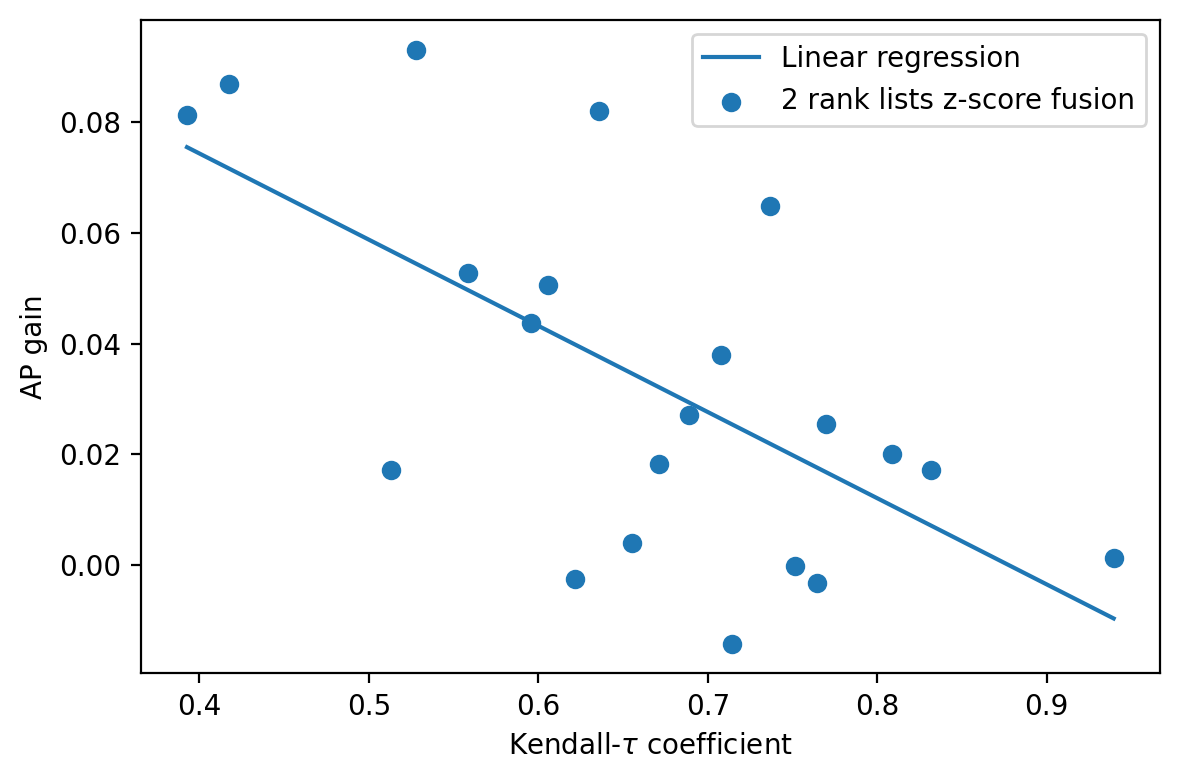

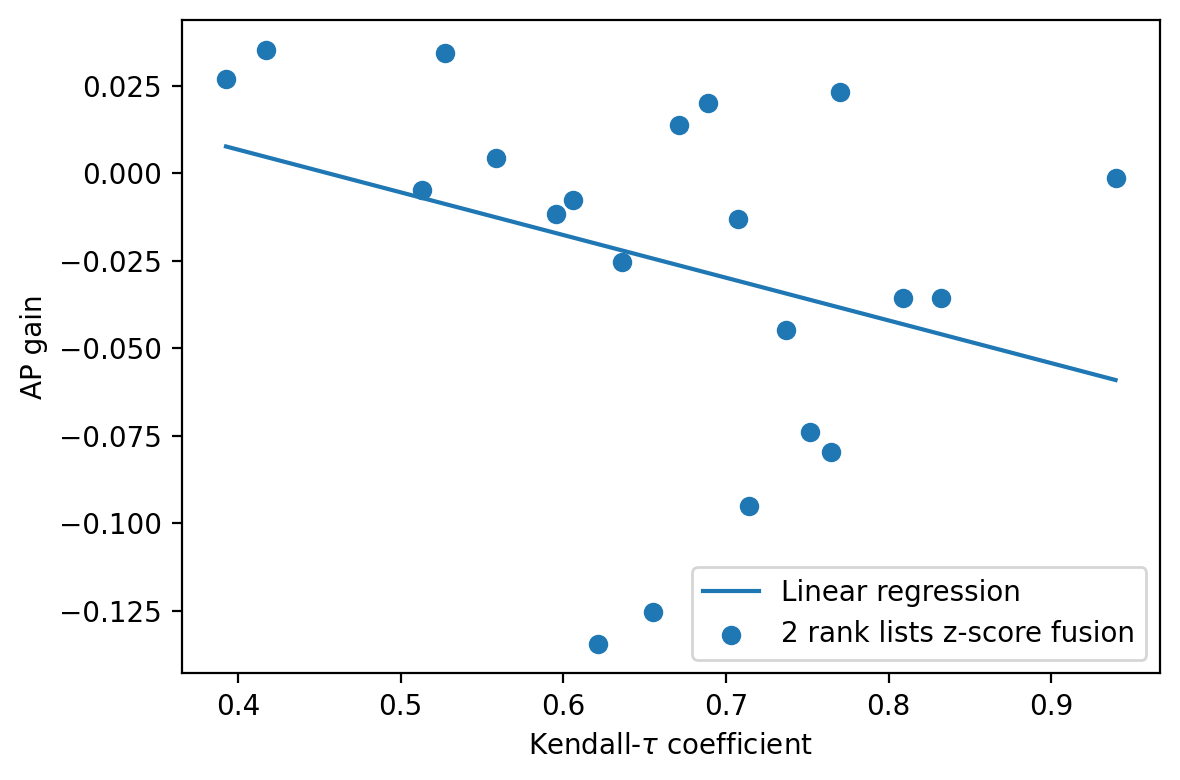

In [81]:
%autoreload 2

def compute_method_rank_list(rls):
    s = len(rls)
    ids = range(s)
    d = []
    for Ai, Bi in itertools.product(ids, ids):
        A, B = rls[Ai], rls[Bi]
        dist = rank_list_distance(A, B)
        d.append(dist)
    d = np.array(d).reshape((s, s))
    return d

def get_ranks(d, rls, Y, aggregation):
    gain, dist_value = [], []
    for ids in itertools.combinations(range(d.shape[0]), 2):
        fusion_rl = [rls[id] for id in ids]
        
        m_single_rls = [evaluate_linking(rl, Y) for rl in fusion_rl]
        m_single = aggregation(m_single_rls, axis=0)
        m_fuse = evaluate_linking(fusion_z_score(fusion_rl), Y)
        diff = m_fuse - m_single
        
        gain.append(diff[0])
        dist_value.append(d[ids])
        
    return np.array(dist_value), np.array(gain)


rls = rls_oxquarry
Y = Y_oxquarry
# rls = rls_brunet
# Y = Y_brunet
# rls = rls_st_jean
# Y = Y_st_jean

d = compute_method_rank_list(rls)
print(d)

def plot(aggregation):
    plt.figure(figsize=(6,4), dpi=200)
    wilcoxon, gain = get_ranks(d, rls, Y, aggregation)
    reg = linregress(wilcoxon, gain)
    slope, intercept, r_value, p_value, std_err = reg
    print(slope, intercept)
    print(f"{r_value:.2f} & {p_value:.2e} & {std_err:.2e}")
    def f(x):
        return slope * x + intercept
    Xs = np.array([np.min(wilcoxon), np.max(wilcoxon)])
    Ys = f(Xs)
    plt.scatter(wilcoxon, gain, label="2 rank lists z-score fusion")
    plt.plot(Xs, Ys, label="Linear regression")
    plt.xlabel(r"Kendall-$\tau$ coefficient")
    plt.ylabel("AP gain")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"img/rank_list_correlation_{aggregation.__name__}.png", facecolor="w")
    
plot(np.mean)
plot(np.max)

## Clustering

### Unsupervised clustering evaluation

bcubed.fscore bcubed.precision bcubed.recall r ratio diff
[0.74 1.00 0.59 0.21]


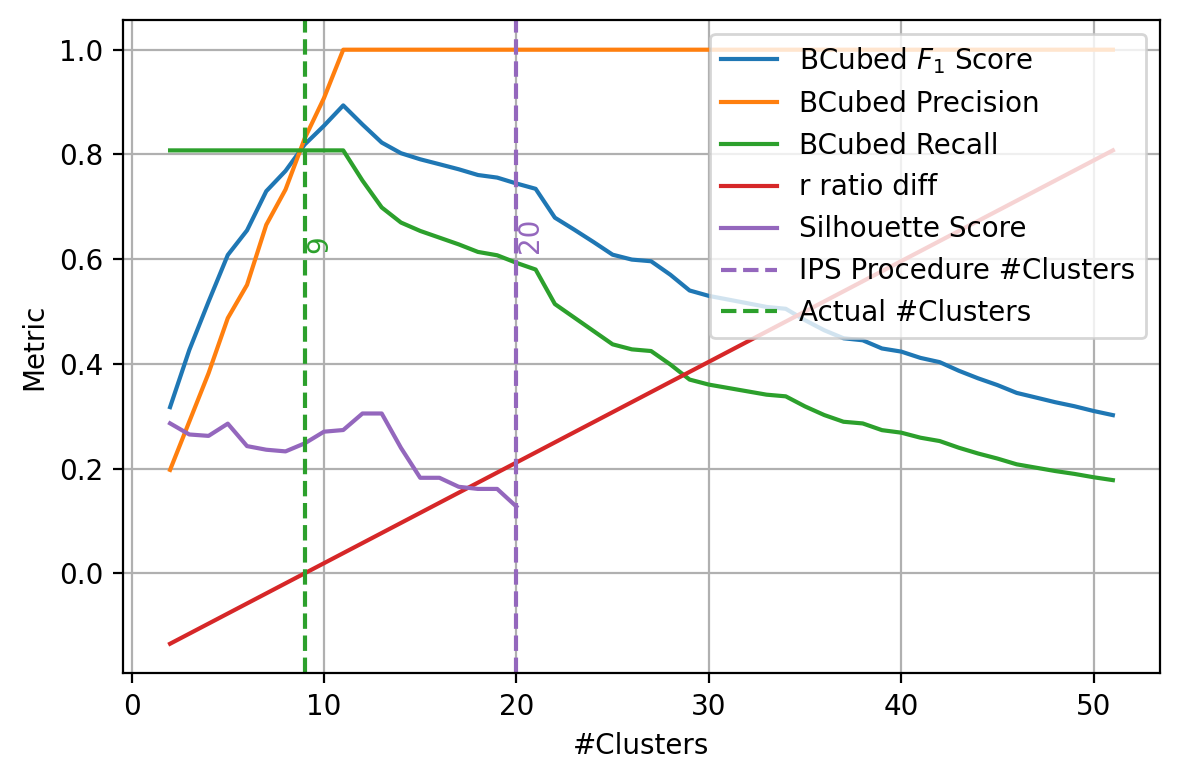

In [62]:
ips_stop = 0.1

%autoreload 2

rl = rl_z_score_oxquarry
Y = Y_oxquarry
# rl = rl_z_score_brunet
# Y = Y_brunet
# rl = rl_z_score_st_jean
# Y = Y_st_jean

labels, silhouette_scores = unsupervised_clustering(rl, ips_stop=ips_stop, return_scores=True)

print("bcubed.fscore", "bcubed.precision", "bcubed.recall", "r ratio diff")
print(evaluate_clustering(Y, labels))

ns, labels_list = clustering_at_every_n_clusters(rl)
evaluations = np.array([evaluate_clustering(Y, labels) for labels in labels_list])

n_clusters_found = len(np.unique(labels))
n_clusters_actual = len(np.unique(Y))

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(ns, evaluations[:, 0], label="BCubed $F_1$ Score")
plt.plot(ns, evaluations[:, 1], label="BCubed Precision")
plt.plot(ns, evaluations[:, 2], label="BCubed Recall")
plt.plot(ns, evaluations[:, 3], label="r ratio diff")
plt.plot(*silhouette_scores, label="Silhouette Score")
plt.axvline(n_clusters_found, 0, 1, ls="dashed", c="C4", label="IPS Procedure #Clusters")
plt.axvline(n_clusters_actual, 0, 1, ls="dashed", c="C2", label="Actual #Clusters")
xmin, xmax, ymin, ymax = plt.axis()
ypos = ymax / 2 - ymin / 2
plt.text(n_clusters_found, ypos, f"{n_clusters_found}", c="C4", rotation="vertical")
plt.text(n_clusters_actual, ypos, f"{n_clusters_actual}", c="C2", rotation="vertical")
plt.legend(loc="upper right")
plt.xlabel("#Clusters")
plt.ylabel("Metric")
plt.grid()
plt.tight_layout()
plt.savefig("img/unsupervised_clustering.png")

In [66]:
# rl = rl_z_score_oxquarry
# Y = Y_oxquarry
# rl = rl_z_score_brunet
# Y = Y_brunet
rl = rl_z_score_st_jean
Y = Y_st_jean

ips_stops = np.linspace(0.0, 0.5, 41)

M = []
for ips_stop in ips_stops:
    labels = unsupervised_clustering(rl, ips_stop=ips_stop)
    M.append(evaluate_clustering(Y, labels))
M = np.array(M)

print(ips_stops[np.argmin(np.abs(M[:, 3]))], np.min(M[:, 3]))

0.1125 -0.145


### Supervised clustering evaluation

In [77]:
datasets = [
    (rl_z_score_oxquarry, Y_oxquarry),
    (rl_z_score_brunet, Y_brunet),
    (rl_z_score_st_jean_A, Y_st_jean_A),
    (rl_z_score_st_jean_B, Y_st_jean_B),
]

dataset_labels = [
    "oxquarry",
    "brunet",
    "st_jean_a",
    "st_jean_b",
]
ids = range(len(datasets))

M = []
for A, B in itertools.product(ids, ids):
    rl_training, Y_training = datasets[A]
    rl_testing, Y_testing = datasets[B]

    model = supervised_clustering_training(rl_training, Y_training)
    Y_pred = supervised_clustering_predict(model, rl_testing)

    m = evaluate_clustering(Y_testing, Y_pred)
    M.append(m)
    print(dataset_labels[A], dataset_labels[B], m)

M = np.array(M)
print(M.mean(axis=0))
M = M.reshape((len(datasets), len(datasets), M.shape[-1]))
print("Testing on average")
print(M.mean(axis=0))
print("Training on average")
print(M.mean(axis=1))

oxquarry oxquarry [0.82 1.00 0.70 0.08]
oxquarry brunet [0.86 0.91 0.82 0.07]
oxquarry st_jean_a [ 0.88  0.84  0.93 -0.03]
oxquarry st_jean_b [ 0.92  0.88  0.98 -0.02]
brunet oxquarry [0.80 1.00 0.67 0.10]
brunet brunet [0.75 0.94 0.62 0.18]
brunet st_jean_a [0.81 0.98 0.69 0.09]
brunet st_jean_b [0.91 1.00 0.83 0.05]
st_jean_a oxquarry [0.80 1.00 0.67 0.10]
st_jean_a brunet [0.82 0.94 0.73 0.11]
st_jean_a st_jean_a [0.87 0.93 0.81 0.03]
st_jean_a st_jean_b [0.97 1.00 0.94 0.02]
st_jean_b oxquarry [0.80 1.00 0.67 0.10]
st_jean_b brunet [0.76 0.94 0.64 0.16]
st_jean_b st_jean_a [0.82 0.96 0.72 0.07]
st_jean_b st_jean_b [0.93 1.00 0.87 0.04]
[0.85 0.96 0.77 0.07]
Testing on average
[[0.81 1.00 0.68 0.09]
 [0.80 0.93 0.70 0.13]
 [0.85 0.93 0.79 0.04]
 [0.93 0.97 0.91 0.02]]
Training on average
[[0.87 0.91 0.86 0.02]
 [0.82 0.98 0.71 0.10]
 [0.86 0.97 0.79 0.06]
 [0.83 0.97 0.73 0.09]]
